# Implement DDPM for image generation using Fashion-MNIST

This code implements the main loop for the diffusion models in Module3

In [ ]:
# Imports

import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

import einops
import imageio

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader
from torch.optim import Adam

#from displayer import show_first_batch, show_images
#from utils_DDPM import DDPM, show_forward, generate_new_images
#from utils_UNet import UNet
#from utils_training import training_loop

print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
import torch
print(torch.__version__)


cuda
2.3.1+cu118


### Load Fashion-MNIST dataset

In [47]:
ds_fn = FashionMNIST

transform = Compose([ToTensor(), Lambda(lambda x: x * 2 - 1)])

dataset = ds_fn(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

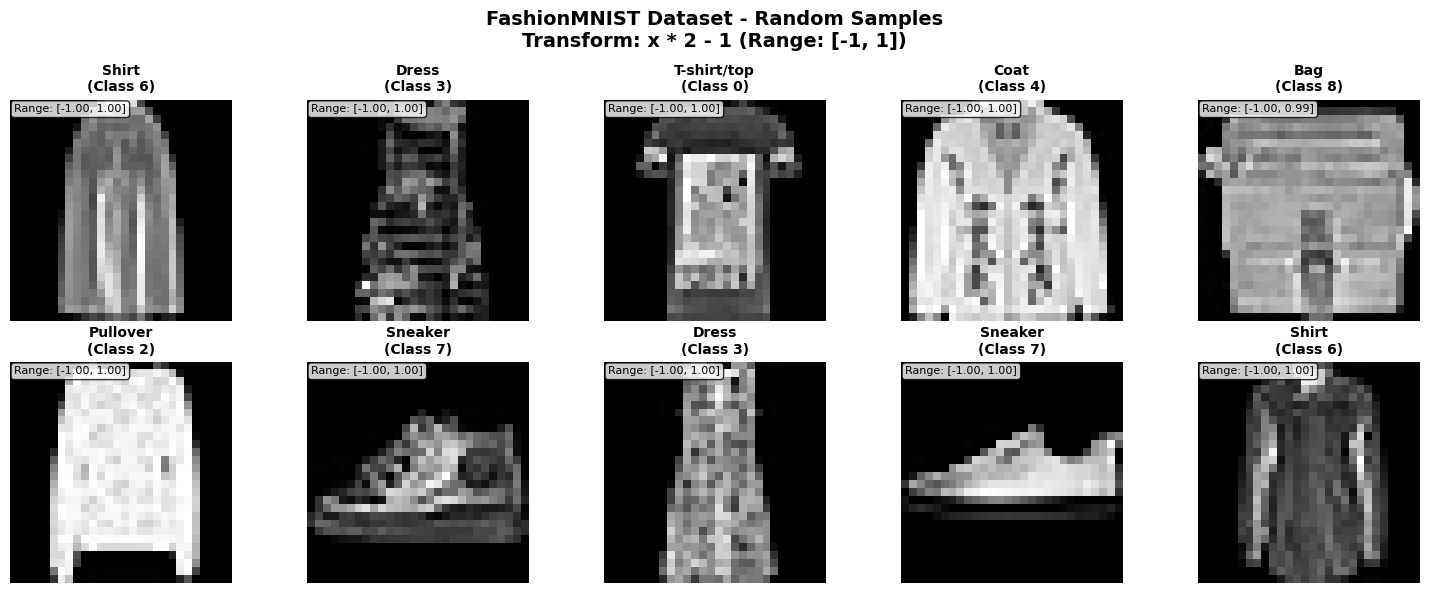

Dataset Statistics:
Total samples: 60000
Number of classes: 10
Image shape: torch.Size([1, 28, 28])
Transform applied: x * 2 - 1
Expected pixel range: [-1, 1]
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Actual pixel range in samples: [-1.000, 1.000]



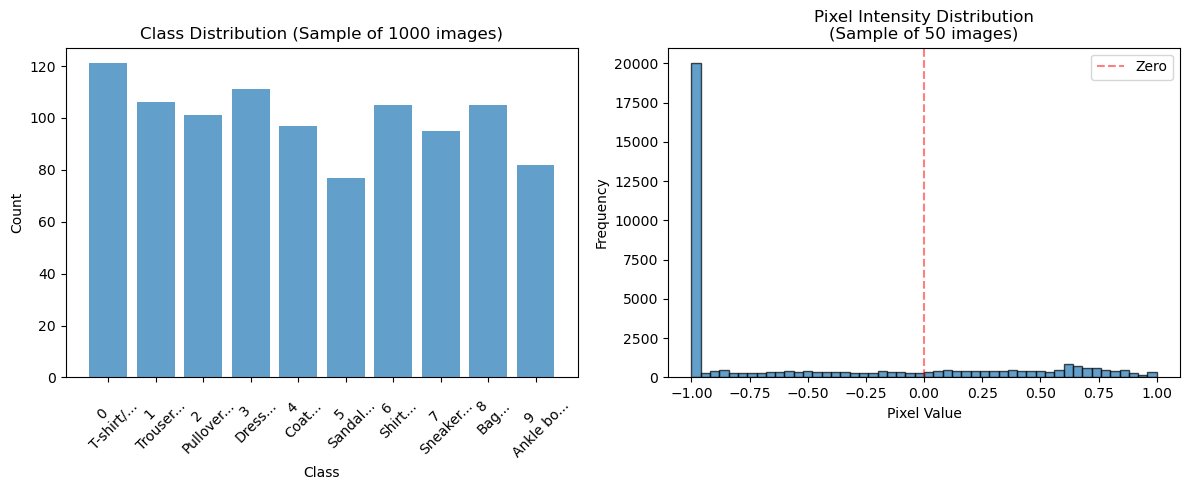

In [46]:
# Visualize dataset

# FashionMNIST class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

def visualize_random_samples(dataset, num_samples=10, figsize=(15, 6)):
    """
    Visualize random samples from the FashionMNIST dataset
    """
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    # Create subplot
    fig, axes = plt.subplots(2, 5, figsize=figsize)
    fig.suptitle('FashionMNIST Dataset - Random Samples\nTransform: x * 2 - 1 (Range: [-1, 1])', 
                 fontsize=14, fontweight='bold')
    
    for i, idx in enumerate(random_indices):
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy and squeeze to remove channel dimension
        # Note: image values are in range [-1, 1] due to transform
        img_np = image.squeeze().numpy()
        
        # Calculate subplot position
        row = i // 5
        col = i % 5
        
        # Display image
        axes[row, col].imshow(img_np, cmap='gray', vmin=-1, vmax=1)
        axes[row, col].set_title(f'{class_names[label]}\n(Class {label})', 
                                fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
        
        # Add pixel value range info
        axes[row, col].text(0.02, 0.98, f'Range: [{img_np.min():.2f}, {img_np.max():.2f}]',
                           transform=axes[row, col].transAxes, 
                           fontsize=8, verticalalignment='top',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


def analyze_dataset_statistics(dataset):
    """
    Analyze and visualize dataset statistics
    """
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Image shape: {dataset[0][0].shape}")
    print(f"Transform applied: x * 2 - 1")
    print(f"Expected pixel range: [-1, 1]")
    print(f"Class names: {class_names}")
    
    # Sample a few images to check actual pixel range
    sample_images = [dataset[i][0] for i in range(0, min(100, len(dataset)), 10)]
    min_vals = [img.min().item() for img in sample_images]
    max_vals = [img.max().item() for img in sample_images]
    
    print(f"Actual pixel range in samples: [{min(min_vals):.3f}, {max(max_vals):.3f}]")
    print()
    
    # Class distribution (sample 1000 items)
    sample_size = min(1000, len(dataset))
    labels = [dataset[i][1] for i in np.random.choice(len(dataset), sample_size, replace=False)]
    
    plt.figure(figsize=(12, 5))
    
    # Class distribution
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Class Distribution (Sample of {sample_size} images)')
    plt.xticks(unique, [f'{i}\n{class_names[i][:8]}...' for i in unique], rotation=45)
    
    # Pixel intensity distribution
    plt.subplot(1, 2, 2)
    sample_pixels = np.concatenate([dataset[i][0].numpy().flatten() 
                                   for i in np.random.choice(len(dataset), 50, replace=False)])
    plt.hist(sample_pixels, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Intensity Distribution\n(Sample of 50 images)')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Zero')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

visualize_random_samples(dataset, num_samples=10, figsize=(15, 6))
analyze_dataset_statistics(dataset)

In [ ]:
# Create DDPM model

class DDPM(nn.Module):
    def __init__(self, network, timesteps=1000, min_beta=1e-4, max_beta=0.02, device='cpu'):
        super(DDPM, self).__init__()
        self.network = network.to(device)
        self.timesteps = timesteps
        self.device = device
        
        # Create beta schedule
        self.betas = torch.linspace(min_beta, max_beta, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

        #self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def forward(self, x, t):
        """
        Forward pass through the DDPM model.
        :param x: Input tensor (batch_size, channels, height, width)
        :param t: Time step tensor (batch_size,)
        :return: Output tensor after applying noise and network
        """
        # Ensure t is a tensor
        if isinstance(t, int):
            t = torch.tensor([t], device=self.device)
        
        # Get beta for the current timestep
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        
        # Add noise to the input
        noise = torch.randn_like(x) * torch.sqrt(beta_t)
        noisy_x = x + noise
        
        # Pass through the network
        output = self.network(noisy_x)
        
        return output



In [ ]:
# Set hyperparameters
random.seed(12)
np.random.seed(12)
torch.manual_seed(12)

batch_size = 128
num_epochs = 10
learning_rate = 1e-3
n_steps = 1000
min_beta = 10**-4
max_beta = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create DDMP